# Overview

This notebook will:
- [ ] Make the final scaling/categorical adjustments to the DataFrame
    - [ ] Still waiting on **annual_powerplant_netgeneration.csv** from merge_data.ipynb. It is missing a Year column to match on.
- [x] Split the Data into Train, Test, Val
    - Currently going with 70% - 15% - 15%
    - 80% - 10% - 10%
- [ ] Train, tune, and store models
    - Model Choices
        - [ ] DecisionTreeRegressor
        - ...


Additional Notes:
- I think we need to shift the DataFrame so that the target variable is COV of the following year. 
- We may have to simplyify the number of features in the model given how wide it has become. Not sure how to best. We may want to discuss a about possiblity of a hierarchy of features to keep, or perhaps an ensemble model that looks at each category of features sepearetly.
    - i.e. a model that looks at net generation, a model that looks at weather, etc.
- How we plan to save models paramters
    - Optuna
    - Neptune.ai
    - manually saved csv file
    - manually saved json file

# Imports

 Synthetic Minority Over-Sampling Technique for Regression ([Source](https://pypi.org/project/smogn/))



In [ ]:
# pip install smogn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
# import utils # utils.draw_tree(clf, feature_names= heart_df.columns)
from pprint import pprint
# import smogn
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Mount Drive

In [2]:
import pandas as pd
from google.colab import drive
import glob

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
%cd /content/drive/Shareddrives/Data606_Energy/data/merge_ready

/content/drive/Shareddrives/Data606_Energy/data/merge_ready


# Read in data

In [5]:
# df = pd.read_csv("merged_data_2001-2020.csv")
df = pd.read_csv("merged_data.csv")

with pd.option_context('display.max_rows', 3, 'display.max_columns', None): 
    display(df)

,Year,State,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months,COV,target_COV,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_Biomass_MWh,R_Biomass_count,R_Coal_MWh,R_Coal_count,R_Geothermal_MWh,R_Geothermal_count,R_Hydroelectric_MWh,R_Hydroelectric_count,R_Municipal_Waste_MWh,R_Municipal_Waste_count,R_Natural_Gas_MWh,R_Natural_Gas_count,R_Nuclear_MWh,R_Nuclear_count,R_OUC_custom_MWh,R_OUC_custom_count,R_Oil_Gas_MWh,R_Oil_Gas_count,R_Other_MWh,R_Other_count,R_Solar_MWh,R_Solar_count,R_Wind_MWh,R_Wind_count,R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,R_batteries_or_other_use_of_electricity_as_an_energy_source_count,Agg_total_plant_MWh_y,Agg_total_plant_count_y,R_AB_MWh,R_AB_count,R_BFG_MWh,R_BFG_count,R_BIT_MWh,R_BIT_count,R_BLQ_MWh,R_BLQ_count,R_DFO_MWh,R_DFO_count,R_GEO_MWh,R_GEO_count,R_JF_MWh,R_JF_count,R_KER_MWh,R_KER_count,R_LFG_MWh,R_LFG_count,R_LIG_MWh,R_LIG_count,R_MSB_MWh,R_MSB_count,R_MSN_MWh,R_MSN_count,R_MSW_MWh,R_MSW_count,R_MWH_MWh,R_MWH_count,R_NG_MWh,R_NG_count,R_NUC_MWh,R_NUC_count,R_OBG_MWh,R_OBG_count,R_OBS_MWh,R_OBS_count,R_OG_MWh,R_OG_count,R_OTH_MWh,R_OTH_count,R_PC_MWh,R_PC_count,R_PG_MWh,R_PG_count,R_PUR_MWh,R_PUR_count,R_RC_MWh,R_RC_count,R_RFO_MWh,R_RFO_count,R_SC_MWh,R_SC_count,R_SGC_MWh,R_SGC_count,R_SLW_MWh,R_SLW_count,R_SUB_MWh,R_SUB_count,R_SUN_MWh,R_SUN_count,R_TDF_MWh,R_TDF_count,R_WAT_MWh,R_WAT_count,R_WC_MWh,R_WC_count,R_WDS_MWh,R_WDS_count,R_WH_MWh,R_WH_count,R_WND_MWh,R_WND_count,R_WO_MWh,R_WO_count,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop
0,2008,AK,10,1,6,7,9,4,11,6,0,4,4,0.039052,0.021611,6.765932e+06,1561,0.0,0.001,0.091,0.038,0.0,0.0,0.173,0.200,0.0,0.0,0.592,0.077,0.0,0.0,0.001,0.008,0.143,0.669,0.000,0.000,0.000,0.000,0.000,0.008,0.0,0.0,6.761251e+06,1549,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.060,0.558,0.0,0.0,0.064,0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.592,0.077,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.019,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.091,0.039,0.000,0.000,0.0,0.0,0.173,0.201,0.0,0.0,0.0,0.001,0.0,0.0,0.000,0.008,0.0,0.000,0.056,0.007,0.451,0.337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,2020,WY,6,7,6,2,6,6,6,6,2,4,4,0.029015,0.042883,3.413598e+07,456,0.0,0.000,0.908,0.289,0.0,0.0,0.000,0.026,0.0,0.0,0.035,0.211,0.0,0.0,0.000,0.000,0.012,0.263,0.002,0.026,0.005,0.026,0.037,0.158,0.0,0.0,3.413598e+07,456,0.0,0.0,0.0,0.0,0.004,0.026,0.0,0.0,0.001,0.158,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035,0.211,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.053,0.002,0.026,0.0,0.0,0.0,0.0,0.0,0.0,0.351,0.053,0.000,0.026,0.0,0.0,0.0,0.0,0.0,0.0,0.553,0.211,0.005,0.026,0.0,0.0,0.000,0.026,0.0,0.0,0.0,0.000,0.0,0.0,0.037,0.158,0.0,0.026,0.059,0.011,0.222,0.187


In [6]:
# with pd.option_context('display.max_rows', 3, 'display.max_columns', None): 
#     display(df[[x for x in df.columns if "count" in x]])

# count_columns = [x for x in df.columns if "count" in x]

# Figure out what columns still need to be scaled

These are the only numerical columns that need to be scaled or dropped.

In [25]:
temp = df.describe().T
temp = temp[temp["max"] > 1].T
temp[[x for x in temp if "Months" not in x]].columns

Index(['State', 'Agg_total_plant_MWh_x', 'Agg_total_plant_count_x',
       'Agg_total_plant_MWh_y', 'Agg_total_plant_count_y'],
      dtype='object')

"Sate" is the only non numerical column. This should be categorized.

In [8]:
numerical_columns = df.select_dtypes(['number']).columns
df[[x for x in df.columns if x not in numerical_columns]].columns

Index(['State'], dtype='object')

In [9]:
columns_to_scale = ["Agg_total_plant_MWh", "Agg_total_plant_count"]

# I think it is better to just divide by 12 here
columns_to_scale_by_Month = [x for x in df if "Months" in x]

columns_to_categorize = ["State"]

columns_to_drop = ["Year"] # Not sure if this is appropriate to keep after matching the data

# Scaling, Categorizing, and Dropping

In [10]:
try:
    df[columns_to_scale] = MinMaxScaler().fit_transform(df[columns_to_scale])
    df[columns_to_scale].head(3)
except:
    # Just means that files were left out for additional rows
    pass

In [11]:
df[columns_to_scale_by_Month] /= 12 
df[columns_to_scale_by_Month].head(3)

,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months
0,0.833333,0.083333,0.5,0.583333,0.75,0.333333,0.916667,0.5,0.000000,0.333333,0.333333
1,0.833333,0.083333,0.5,0.583333,0.75,0.333333,0.916667,0.5,0.000000,0.333333,0.333333
2,0.833333,0.083333,0.5,0.583333,0.75,0.333333,0.916667,0.5,0.083333,0.333333,0.250000


https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes

In [12]:
# not using columns_to_categorize because it is just `State`
codes = df.State.astype("category")

state_codes = dict(enumerate(codes.cat.categories))
# print(state_codes)

df["State"] = df.State.astype("category").cat.codes
df["State"].head(3)

0    0
1    1
2    2
Name: State, dtype: int8

Not sure if we keep or drop year for the model.

In [13]:
df = df.drop(columns="Year")

# Test (80%), Train (10%), Val (10%) Split

For repeatability

In [14]:
random_state = 0

This is the COV for the following year.

In [15]:
target = "target_COV"

In [103]:
X = df.drop(columns=["COV", target])
# X = df[count_columns]
y = df[target]# * 100 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, 
                                                    random_state=random_state,
                                                    shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, 
                                                    random_state=random_state)

**SMOGN**: Additional Data with Oversampling for the Training data
- not sure why, but I cant get the dataframe to expand from oversampling

In [17]:
# df_smogn = smogn.smoter(
#     data = df, 
#     y = target,
#     rel_ctrl_pts_rg = [
#         [target, 1, 0]
#     ]
# )
# print(f"len(df):\t{df.shape}")
# print(f"len(df_smogn):\t{df_smogn.shape}")

# print(round((len(df_smogn) - len(df)) / len(df), 2))

**SMOTE**

In [18]:
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

In [104]:
print(f"len(X):\t{len(X)}")
print(f"len(X_train):\t{len(X_train)}")
print(f"len(X_test):\t{len(X_test)}")
print(f"len(X_val):\t{len(X_val)}")

len(X):	650
len(X_train):	390
len(X_test):	130
len(X_val):	130


# Modeling

In [97]:
parameters = {
    "random_state" : [random_state],
    "max_depth" : range(1, 2*len(X_train.columns)),
    #"criterion" : ["mse", "friedman_mse", "mae"],
    "criterion" : ["mse"],
    "min_samples_leaf" : range(1, 10),
    "max_features" : ["sqrt", "auto", "sqrt", "log2"]
}

model = GridSearchCV(DecisionTreeRegressor(), parameters, scoring="r2")
%time model.fit(X_train, y_train)

CPU times: user 3min 53s, sys: 717 ms, total: 3min 54s
Wall time: 3min 53s


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse'], 'max_depth': range(1, 240),
                         'max_features': ['sqrt', 'auto', 'sqrt', 'log2'],
  

In [98]:
temp = pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score", ascending=True)
pprint(temp[temp.rank_test_score == 1].iloc[0].params)

temp.head(3)

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'random_state': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
326,0.002639,0.000180,0.001031,0.000231,mse,10,sqrt,3,0,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.542426,0.626412,0.737502,0.674654,0.594153,0.635030,0.06692,1
344,0.002597,0.000138,0.000902,0.000004,mse,10,sqrt,3,0,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.542426,0.626412,0.737502,0.674654,0.594153,0.635030,0.06692,1
433,0.002728,0.000043,0.000926,0.000047,mse,13,sqrt,2,0,"{'criterion': 'mse', 'max_depth': 13, 'max_fea...",0.485504,0.585845,0.726216,0.676448,0.624482,0.619699,0.08215,3


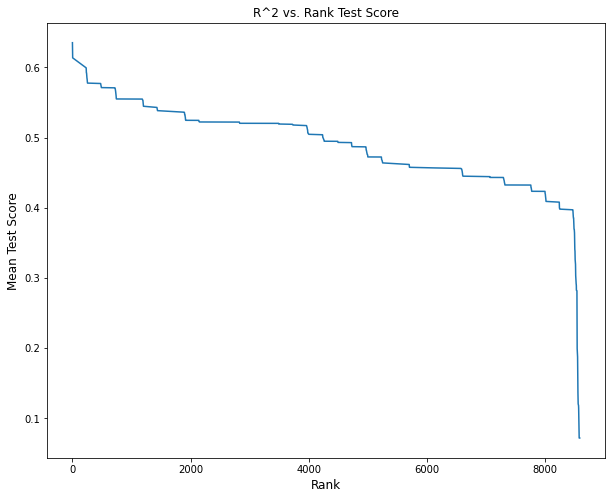

In [99]:
plt.figure(figsize=(10,8))
plt.plot(temp[temp.mean_test_score > 0]["rank_test_score"],
         temp[temp.mean_test_score > 0]["mean_test_score"])#, color=param_criterion)

# sns.relplot(data=temp[temp.mean_test_score > 0], x='rank_test_score',
#             y='mean_test_score', hue='param_max_depth')#, hue_order=_genders, aspect=1.61)

plt.xlabel("Rank", fontsize="large")
plt.ylabel("Mean Test Score", fontsize="large")
plt.title("R^2 vs. Rank Test Score")
plt.show()

In [100]:
model.scorer_, round(model.best_score_, 2)

(make_scorer(r2_score), 0.64)

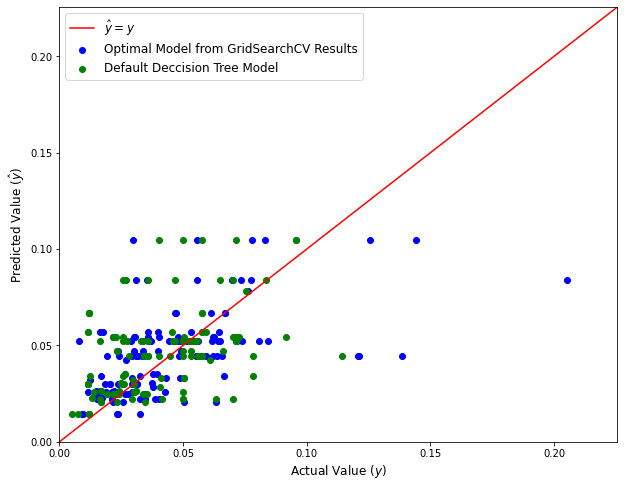

In [102]:
y_hat = manual_grid_search_model.fit(X_train, y_train).predict(X_test)
random_model_y_hat = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train).predict(X_test)

plt.figure(figsize=(10,8))
plt.scatter(y_test, y_hat, color="blue", label="Optimal Model from GridSearchCV Results")
plt.scatter(random_model_y_hat, y_hat, color="green", label="Default Deccision Tree Model")
# plt.scatter(y_test, y_test, label="Ideal")

max_val = max(max(y_test), max(y_hat))
max_val = 1.1*max(max_val, max(random_model_y_hat))

x = np.linspace(0, max_val, 1000)
plt.plot(x, x, color="red", label="$\hat{y} = y$")
plt.xlabel("Actual Value ($y$)", fontsize="large")
plt.ylabel("Predicted Value ($\hat{y}$)", fontsize="large")
plt.legend(fontsize="large")
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.show()

In [110]:
print("MSE:\t{:.4f}".format(mean_squared_error(y_test, y_hat)))
print("MAE:\t{:.4f}".format(mean_absolute_error(y_test, y_hat)))

R2 = r2_score(y_test, y_hat)
n = len(X_test)
k = len(X_test.columns)
adj_r_squared = 1 - ((1-R2)*(n-1)/(n-k-1))

print("R^2:\t{:.4f}".format(R2))
print("Adjusted R^2:\t{:.4f}".format(adj_r_squared))

MSE:	0.0006
MAE:	0.0164
R^2:	0.2715
Adjusted R^2:	-9.4416


In [111]:
random_model_y_hat = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train).predict(X_test)

print("MSE:\t{:.4f}".format(mean_squared_error(y_test, random_model_y_hat)))
print("MAE:\t{:.4f}".format(mean_absolute_error(y_test, random_model_y_hat)))

R2 = r2_score(y_test, random_model_y_hat)
n = len(X_test)
k = len(X_test.columns)
adj_r_squared = 1 - ((1-R2)*(n-1)/(n-k-1))

print("R^2:\t{:.4f}".format(R2))
print("Adjusted R^2:\t{:.4f}".format(adj_r_squared))

MSE:	0.0007
MAE:	0.0176
R^2:	0.1139
Adjusted R^2:	-11.7002


# Manual Grid Search
Not sure whats wrong with GridSearchCV but I will try it mannually

In [ ]:
manual_grid_search_df = pd.DataFrame(columns=["random_state", "criterion", "min_samples_leaf",
                                              "max_features", "R2", "R2_adjusted"])

for max_depth in tqdm(parameters["max_depth"], desc="Max Depth"):
    for criterion in tqdm(parameters["criterion"], desc="Criterion"):
        for min_samples_leaf in tqdm(parameters["min_samples_leaf"], desc="Min Samples Leaf"):
            # for max_features in tqdm(parameters["max_features"], desc="Max Features"):
            for max_features in tqdm(["sqrt"], desc="Max Features"):

                
                model = DecisionTreeRegressor(
                    random_state = random_state,
                    criterion = criterion,
                    max_depth = max_depth,
                    max_features = max_features,
                    min_samples_leaf = min_samples_leaf)
                
                model.fit(X_train, y_train)

                R2 = r2_score(y_test, model.predict(X_test))
                n = len(X_test)
                k = len(X_test.columns)
                adj_r_squared = 1 - ((1-R2)*(n-1)/(n-k-1))

                model_details = {
                    "random_state" : random_state,
                    "criterion" : criterion,
                    "max_depth" : max_depth,
                    "max_features" : max_features,
                    "min_samples_leaf" : min_samples_leaf,
                    "R2" : R2,
                    "R2_adjusted" : adj_r_squared
                }

                manual_grid_search_df = manual_grid_search_df.append(model_details, ignore_index=True)

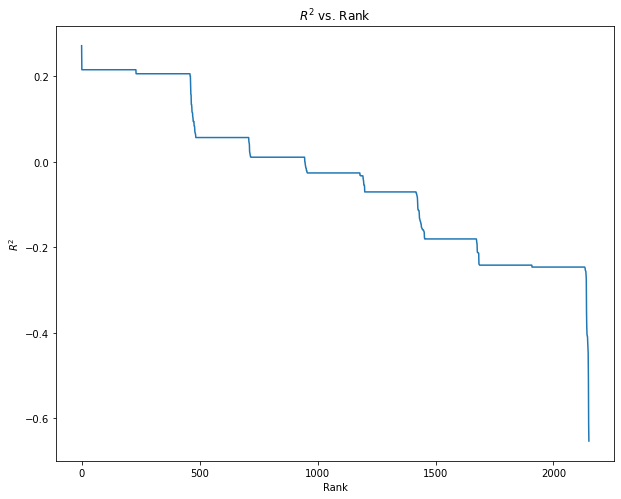

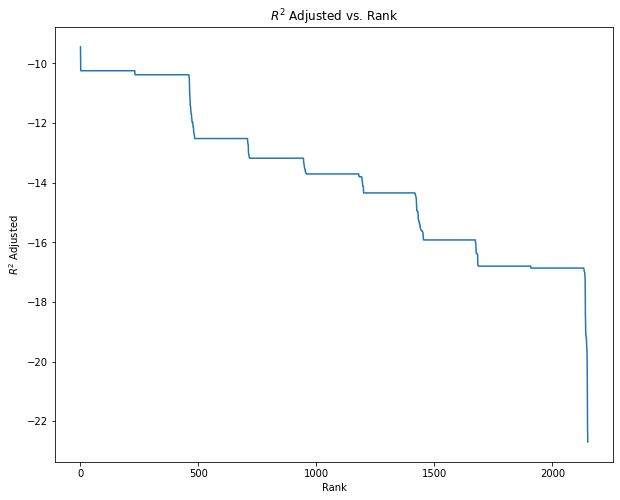

In [105]:
for score in ["R2", "R2_adjusted"]:
    plt.figure(figsize=(10,8))
    plt.plot(range(len(manual_grid_search_df.index)), manual_grid_search_df.sort_values(by=score, ascending=False)[score])
    if score == "R2":
        plt.title("$R^2$ vs. Rank")
        plt.ylabel("$R^2$")
    else:
        plt.title("$R^2$ Adjusted vs. Rank")
        plt.ylabel("$R^2$ Adjusted")
    plt.xlabel("Rank")
    plt.show()

In [82]:
params = manual_grid_search_df[manual_grid_search_df.R2 == manual_grid_search_df.R2.max()].iloc[0]
manual_grid_search_model = DecisionTreeRegressor(
    random_state = params["random_state"],
    criterion = params["criterion"],
    max_depth = params["max_depth"],
    max_features = params["max_features"],
    min_samples_leaf = params["min_samples_leaf"]
)
manual_grid_search_model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8.0,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

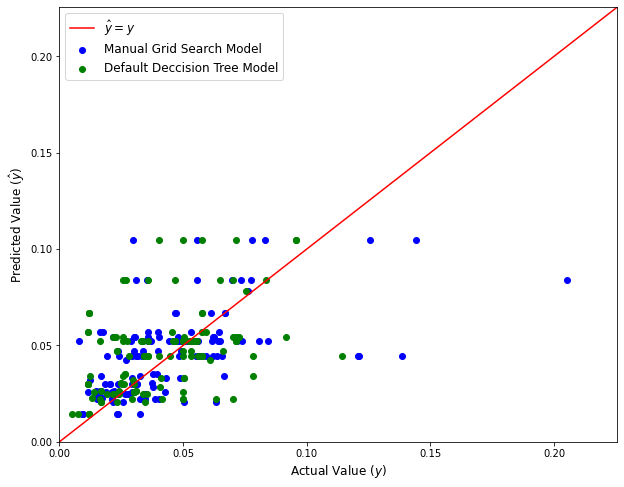

In [115]:
y_hat = manual_grid_search_model.fit(X_train, y_train).predict(X_test)
random_model_y_hat = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train).predict(X_test)

plt.figure(figsize=(10,8))
plt.scatter(y_test, y_hat, color="blue", label="Manual Grid Search Model")
plt.scatter(random_model_y_hat, y_hat, color="green", label="Default Deccision Tree Model")
# plt.scatter(y_test, y_test, label="Ideal")

max_val = max(max(y_test), max(y_hat))
max_val = 1.1*max(max_val, max(random_model_y_hat))

x = np.linspace(0, max_val, 1000)
plt.plot(x, x, color="red", label="$\hat{y} = y$")
plt.xlabel("Actual Value ($y$)", fontsize="large")
plt.ylabel("Predicted Value ($\hat{y}$)", fontsize="large")
plt.legend(fontsize="large")
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.show()

# Choosing Best Model for Predictions

In [ ]:
params = temp[temp.rank_test_score == 1].iloc[0].params
params

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'random_state': 0}

In [113]:
final_model = DecisionTreeRegressor(
    random_state = params["random_state"],
    criterion = params["criterion"],
    max_depth = params["max_depth"],
    max_features = params["max_features"],
    min_samples_leaf = params["min_samples_leaf"])
%time final_model.fit(X_train, y_train)

CPU times: user 4.53 ms, sys: 1.04 ms, total: 5.57 ms
Wall time: 4.66 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8.0,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [116]:
# y_hat = final_model.predict(X_test)
print("MSE:\t{:.4f}".format(mean_squared_error(y_test, y_hat)))
print("MAE:\t{:.4f}".format(mean_absolute_error(y_test, y_hat)))

R2 = r2_score(y_test, y_hat)
n = len(X_test)
k = len(X_test.columns)

# R2: The R2 of the model
# n: The number of observations
# k: The number of predictor variables

adj_r_squared = 1 - ((1-R2)*(n-1)/(n-k-1))

print("R^2:\t{:.2f}".format(R2))
print("Adjusted R^2:\t{:.2f}".format(adj_r_squared))

MSE:	0.0006
MAE:	0.0164
R^2:	0.27
Adjusted R^2:	-9.44


In [96]:
random_model_y_hat = DecisionTreeRegressor(random_state=random_state).fit(X_train, y_train).predict(X_test)

print("MSE:\t{:.4f}".format(mean_squared_error(y_test, random_model_y_hat)))
print("MAE:\t{:.4f}".format(mean_absolute_error(y_test, random_model_y_hat)))

R2 = r2_score(y_test, random_model_y_hat)
n = len(X_test)
k = len(X_test.columns)

# R2: The R2 of the model
# n: The number of observations
# k: The number of predictor variables

adj_r_squared = 1 - ((1-R2)*(n-1)/(n-k-1))

print("R^2:\t{:.2f}".format(R2))
print("Adjusted R^2:\t{:.2f}".format(adj_r_squared))

MSE:	0.0007
MAE:	0.0176
R^2:	0.27
Adjusted R^2:	-9.44


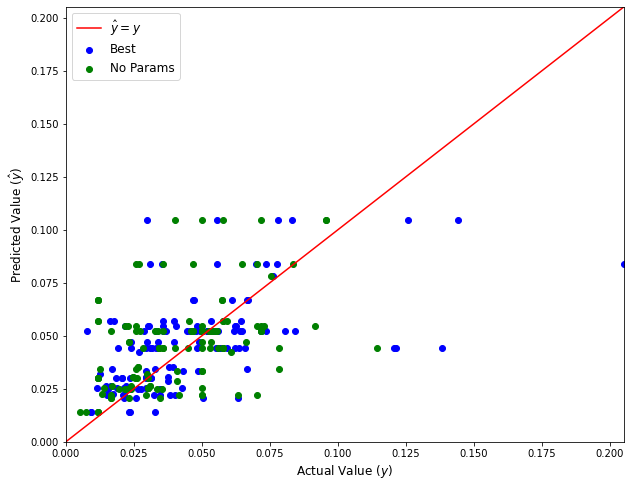

In [118]:
plt.figure(figsize=(10,8))
plt.scatter(y_test, y_hat, color="blue", label="Best")
plt.scatter(random_model_y_hat, y_hat, color="green", label="No Params")
# plt.scatter(y_test, y_test, label="Ideal")

max_val = max(max(y_test), max(y_hat))
max_val = max(max_val, max(random_model_y_hat))

x = np.linspace(0, max_val, 1000)
plt.plot(x, x, color="red", label="$\hat{y} = y$")
plt.xlabel("Actual Value ($y$)", fontsize="large")
plt.ylabel("Predicted Value ($\hat{y}$)", fontsize="large")
plt.legend(fontsize="large")
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.show()

In [ ]:
data = pd.read_csv("merged_data.csv")

st = df[df[target] == df[target].max()].State.iloc[0]
st = state_codes[st]
yr = data[data[target] == data[target].max()].Year.iloc[0]


data[(data.Year==yr) & (data.State==st)]

,Year,State,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months,COV,target_COV,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_Biomass_MWh,R_Biomass_count,R_Coal_MWh,R_Coal_count,R_Geothermal_MWh,R_Geothermal_count,R_Hydroelectric_MWh,R_Hydroelectric_count,R_Municipal_Waste_MWh,R_Municipal_Waste_count,R_Natural_Gas_MWh,R_Natural_Gas_count,R_Nuclear_MWh,R_Nuclear_count,R_OUC_custom_MWh,R_OUC_custom_count,R_Oil_Gas_MWh,R_Oil_Gas_count,R_Other_MWh,R_Other_count,R_Solar_MWh,R_Solar_count,R_Wind_MWh,...,R_OTH_MWh,R_OTH_count,R_PC_MWh,R_PC_count,R_PG_MWh,R_PG_count,R_PUR_MWh,R_PUR_count,R_RC_MWh,R_RC_count,R_RFO_MWh,R_RFO_count,R_SC_MWh,R_SC_count,R_SGC_MWh,R_SGC_count,R_SLW_MWh,R_SLW_count,R_SUB_MWh,R_SUB_count,R_SUN_MWh,R_SUN_count,R_TDF_MWh,R_TDF_count,R_WAT_MWh,R_WAT_count,R_WC_MWh,R_WC_count,R_WDS_MWh,R_WDS_count,R_WH_MWh,R_WH_count,R_WND_MWh,R_WND_count,R_WO_MWh,R_WO_count,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop
635,2020,OK,6,7,6,2,6,6,6,6,1,2,4,0.06452,0.64871,65409654.35,936,0.005,0.064,0.091,0.128,0.0,0.0,-0.002,0.013,0.0,0.013,0.633,0.269,0.0,0.0,0.0,0.0,0.0,0.154,0.0,0.0,0.001,0.077,0.272,...,0.0,0.0,0.0,0.013,0.0,0.0,0.0,0.0,0.0,0.013,0.0,0.026,0.0,0.0,0.0,0.0,0.0,0.0,0.089,0.09,0.001,0.077,0.0,0.013,-0.002,0.013,0.0,0.0,0.0,0.026,0.0,0.0,0.272,0.282,0.0,0.0,0.056,0.011,0.295,0.381


In [ ]:
df.columns

Index(['State', 'Months Above Average Price Movement BZ=F',
       'Months Above Average Price Volume BZ=F',
       'Months Above Average Price Movement NG=F',
       'Months Above Average Price Volume NG=F',
       'Months Above Average Price Movement CL=F',
       'Months Above Average Price Volume CL=F',
       'Months Above Average Price Movement HO=F',
       'Months Above Average Price Volume HO=F', 'Hot Summer Months',
       'Cold Winter Months', 'Dry Summer Months', 'COV', 'target_COV',
       'COM_percapita_mean_kWh_electricacc',
       'RES_percapita_mean_kWh_electricacc', 'COM_percapita_mean_kWh_statepop',
       'RES_percapita_mean_kWh_statepop'],
      dtype='object')